In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
import mne
from nice.algorithms.connectivity import epochs_compute_wsmi
from scipy.stats import zscore
from scipy.signal import detrend
import copy
np.set_printoptions(threshold=100)  # Default threshold
mne.set_log_level('WARNING')
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)


c:\Users\joshu\nice\.venv\Lib\site-packages\mne\externals\tempita\__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


In [2]:
def preprocess(data):
    zeros = np.zeros_like(data)
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
   
    std[std == 0] = 1  # Avoid division by zero by setting std to 1 where it is 0
    zeros = (data - mean) / std
    return zeros

In [3]:
run_time = time.time()
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

classes_left = np.arange(0, 20)
classes_right = np.arange(0, 20)

agg_structure = {cl: 
                  {cr: [] for cr in classes_right} for cl in classes_left} 


l_al_data = copy.deepcopy(agg_structure)
r_al_data = copy.deepcopy(agg_structure)
a_al_data = copy.deepcopy(agg_structure)

l_ar_data = copy.deepcopy(agg_structure)
r_ar_data = copy.deepcopy(agg_structure)
a_ar_data = copy.deepcopy(agg_structure)


n_values = {cl:
             {cr: {
                'attleft': [],
                'attright': []
                } for cr in classes_right} for cl in classes_left} 

#loading the data by class combinations

for file_number in file_numbers:   #will first load the file and extract the data
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    data = pickle.load(open(file_path, 'rb'))

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data["omit"][0]
    relevant = np.where(omitted == 0)[0]    #indices of agg where not omitted

    left_input_LFP = preprocess(data['LFP'][0][0][relevant])
    right_input_LFP = preprocess(data['LFP'][0][1][relevant])
    attention_LFP = preprocess(data['LFP_rec'][0][2][relevant])

    for cl in classes_left:
        for cr in classes_right: 
    
            left_indices_agg = np.where((omitted ==0) & (attend_01 == 0) & (label_left == cl) & (label_right == cr))[0]
            left_indices = np.where(np.isin(relevant, left_indices_agg))[0]
            right_indices_agg = np.where((omitted ==0) & (attend_01 == 1) & (label_left == cl) & (label_right == cr))[0]
            right_indices = np.where(np.isin(relevant, right_indices_agg))[0]
       
            n_values[cl][cr][f'attleft'] = [len(left_indices)]  #e.g. checks number of trials of this class combo for attentino left
            n_values[cl][cr][f'attright'] = [len(right_indices)]  #nb need both left and right indices to be non empty

            if len(left_indices) >= 1:
                l_al = left_input_LFP[left_indices][:, 100:350]
                r_al = right_input_LFP[left_indices][:, 100:350]
                a_al = attention_LFP[left_indices][:, 100:350]

                l_al_data[cl][cr].append(l_al)
                r_al_data[cl][cr].append(r_al)
                a_al_data[cl][cr].append(a_al)

            if len(right_indices) >= 1:

                l_ar = left_input_LFP[right_indices][:, 100:350]
                r_ar = right_input_LFP[right_indices][:, 100:350]
                a_ar = attention_LFP[right_indices][:, 100:350]

                l_ar_data[cl][cr].append(l_ar)   
                r_ar_data[cl][cr].append(r_ar)
                a_ar_data[cl][cr].append(a_ar)

            if cl == 1 and cr == 1:
                print('found a 11')
                print(left_indices)

          

    del data
    gc.collect()



found a 11
[431 548]
found a 11
[251]
found a 11
[]
found a 11
[490]
found a 11
[]
found a 11
[ 37 525 598]
found a 11
[248]
found a 11
[146 695 860 981]


In [4]:
for cl in classes_left:
    for cr in classes_right:
        if len(l_al_data[cl][cr]) > 0:
            l_al_data[cl][cr] = np.concatenate(l_al_data[cl][cr], axis = 0)
            r_al_data[cl][cr] = np.concatenate(r_al_data[cl][cr], axis = 0)
            a_al_data[cl][cr] = np.concatenate(a_al_data[cl][cr], axis = 0)

            l_ar_data[cl][cr] = np.concatenate(l_ar_data[cl][cr], axis = 0)
            r_ar_data[cl][cr] = np.concatenate(r_ar_data[cl][cr], axis = 0)
            a_ar_data[cl][cr] = np.concatenate(a_ar_data[cl][cr], axis = 0)
            

        else:
            print(f"No data for class left {cl} and class right {cr}.")


##-----------------calculating the number of trials for each class pair----------------
n_values_sum = {cl: {cr: {'attleft': 0, 'attright': 0} for cr in classes_right} for cl in classes_left}


for cl in classes_left:
    for cr in classes_right:
        n_values_sum[cl][cr]['attleft'] = len(l_al_data[cl][cr]) 
        n_values_sum[cl][cr]['attright'] = len(l_ar_data[cl][cr]) 
        

In [6]:
#-------------wsmi calculation----------------
sfreq = 500.0
n_times = 250
kernel = 3
taus = [8, 16, 32, 64]  # in ms
wsmi_results = {'left': {}, 'right': {}}
ch_names = ['left_input', 'right_input', 'attention_layer']
ch_types = ['eeg', 'eeg', 'eeg']
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)


lr_split_structure = {cl: {cr: {
    'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []
    } for cr in classes_right} for cl in classes_left}


wsmi_means = copy.deepcopy(lr_split_structure)
wsmi_stdevs = copy.deepcopy(lr_split_structure)


for cl in classes_left:
    wsmi_start = time.time()
    for cr in classes_right: 

        if n_values_sum[cl][cr]['attleft'] == 0:  ##this makes sure you only calulate for left class pairs that have trials
            print('missing data for pair:', cl, cr)
            continue                    

        #reshaping data for attention left
        data_left = np.stack([
            l_al_data[cl][cr], 
            r_al_data[cl][cr],
            a_al_data[cl][cr]
        ], axis=1)

        epochs_left = mne.EpochsArray(
            data_left, 
            info, 
            tmin=0,
            baseline=None,
        )
        

        for tau in taus:
            tau_samples = int(tau / (1000 / sfreq))
                        
            wsmi_results['left'][tau], *_ = epochs_compute_wsmi(
                epochs_left, kernel=kernel, tau=tau_samples,
                backend='python', method_params={'bypass_csd': True}
            )
        
        wsmi_run_time = time.time() - wsmi_start
        
          
        for tau in taus:
            wsmi_means[cl][cr]['left_attleft'].append(np.mean(wsmi_results['left'][tau][0, 2, :]))  #taking the mean across trials
            wsmi_means[cl][cr]['right_attleft'].append(np.mean(wsmi_results['left'][tau][1, 2, :]))
    
            wsmi_stdevs[cl][cr]['left_attleft'].append(np.std(wsmi_results['left'][tau][0, 2, :], ddof = 1))
            wsmi_stdevs[cl][cr]['right_attleft'].append(np.std(wsmi_results['left'][tau][1, 2, :], ddof = 1))

    print(f"wSMI calculated for all left {cl} in {wsmi_run_time:.2f} seconds")


for cl in classes_left:
    wsmi_start = time.time()
    for cr in classes_right: 

        if n_values_sum[cl][cr]['attright'] == 0:  ##this makes sure you only calulate for left class pairs that have trials
            print('missing data for pair:', cl, cr)
            continue                    

        #reshaping data for attention right
        data_right = np.stack([
            l_ar_data[cl][cr], 
            r_ar_data[cl][cr],
            a_ar_data[cl][cr]
        ], axis=1)
    
        epochs_right = mne.EpochsArray(
            data_right, 
            info, 
            tmin=0,
            baseline=None,
        )
        

        for tau in taus:
            tau_samples = int(tau / (1000 / sfreq))
                        
            wsmi_results['right'][tau], *_ = epochs_compute_wsmi(
                epochs_right, kernel=kernel, tau=tau_samples,
                backend='python', method_params={'bypass_csd': True}
            )
        
        wsmi_run_time = time.time() - wsmi_start
        
          
        for tau in taus:
            wsmi_means[cl][cr]['left_attright'].append(np.mean(wsmi_results['right'][tau][0, 2, :]))  #taking the mean across trials
            wsmi_means[cl][cr]['right_attright'].append(np.mean(wsmi_results['right'][tau][1, 2, :]))
    
            wsmi_stdevs[cl][cr]['left_attright'].append(np.std(wsmi_results['right'][tau][0, 2, :], ddof = 1))
            wsmi_stdevs[cl][cr]['right_attright'].append(np.std(wsmi_results['right'][tau][1, 2, :], ddof = 1))

    print(f"wSMI calculated for all right {cl} in {wsmi_run_time:.2f} seconds")

run_time = time.time() - run_time
print(f"Total run time = {run_time:.2f} seconds")

wSMI calculated for all left 0 in 3.02 seconds
wSMI calculated for all left 1 in 3.00 seconds
wSMI calculated for all left 2 in 3.11 seconds
wSMI calculated for all left 3 in 2.60 seconds
wSMI calculated for all left 4 in 3.22 seconds
wSMI calculated for all left 5 in 2.96 seconds
wSMI calculated for all left 6 in 3.11 seconds
wSMI calculated for all left 7 in 2.68 seconds
wSMI calculated for all left 8 in 3.01 seconds
wSMI calculated for all left 9 in 2.78 seconds
wSMI calculated for all left 10 in 3.33 seconds
wSMI calculated for all left 11 in 3.57 seconds
wSMI calculated for all left 12 in 3.13 seconds
wSMI calculated for all left 13 in 3.37 seconds
wSMI calculated for all left 14 in 3.14 seconds
wSMI calculated for all left 15 in 3.06 seconds
wSMI calculated for all left 16 in 3.57 seconds
wSMI calculated for all left 17 in 2.97 seconds
wSMI calculated for all left 18 in 3.44 seconds
wSMI calculated for all left 19 in 2.83 seconds
wSMI calculated for all right 0 in 2.81 seconds
wS

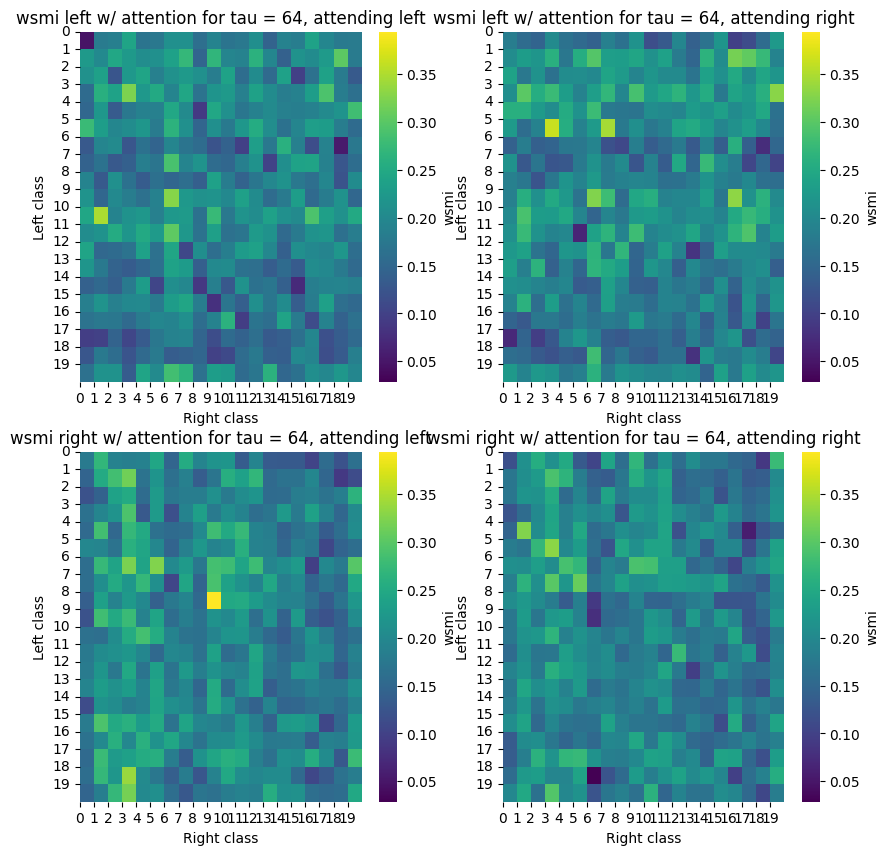

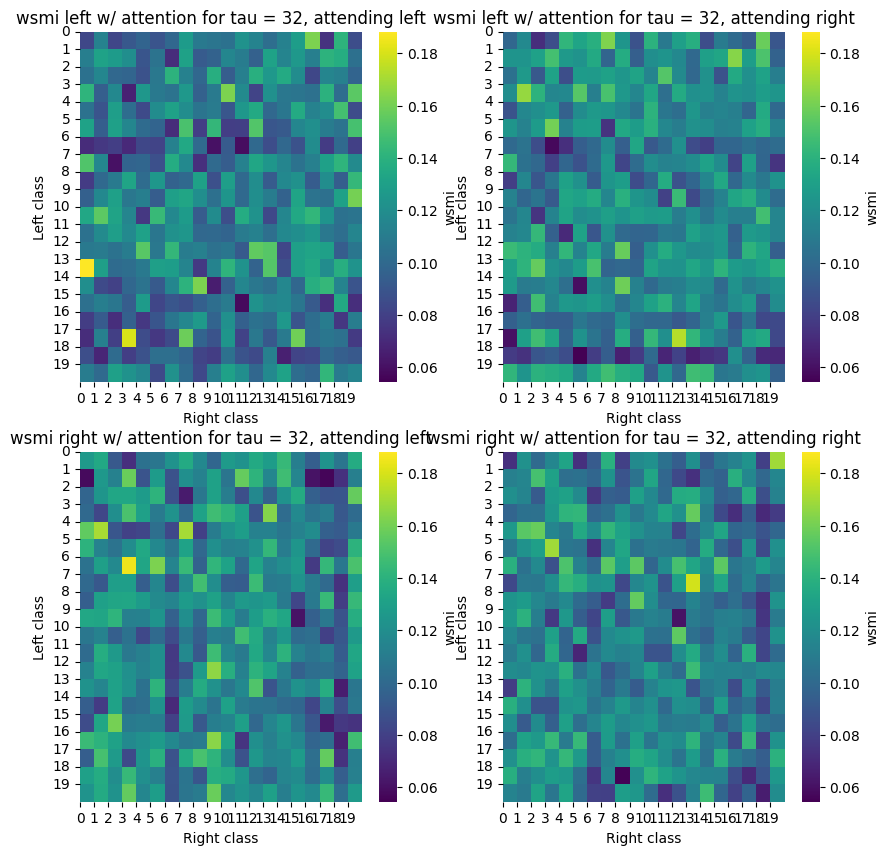

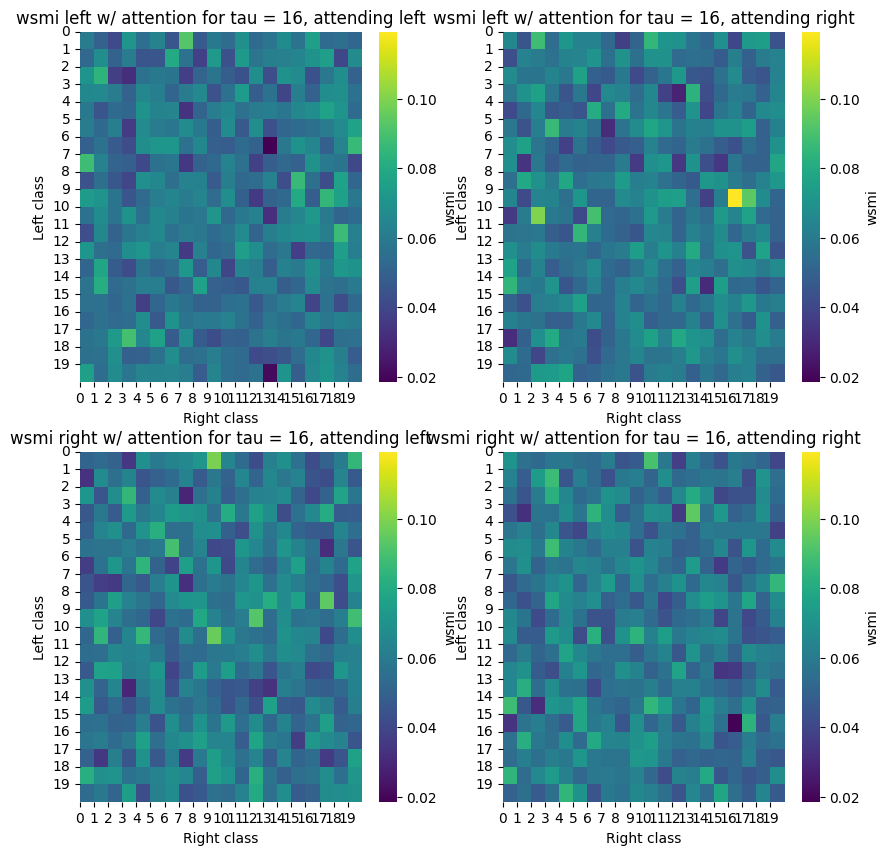

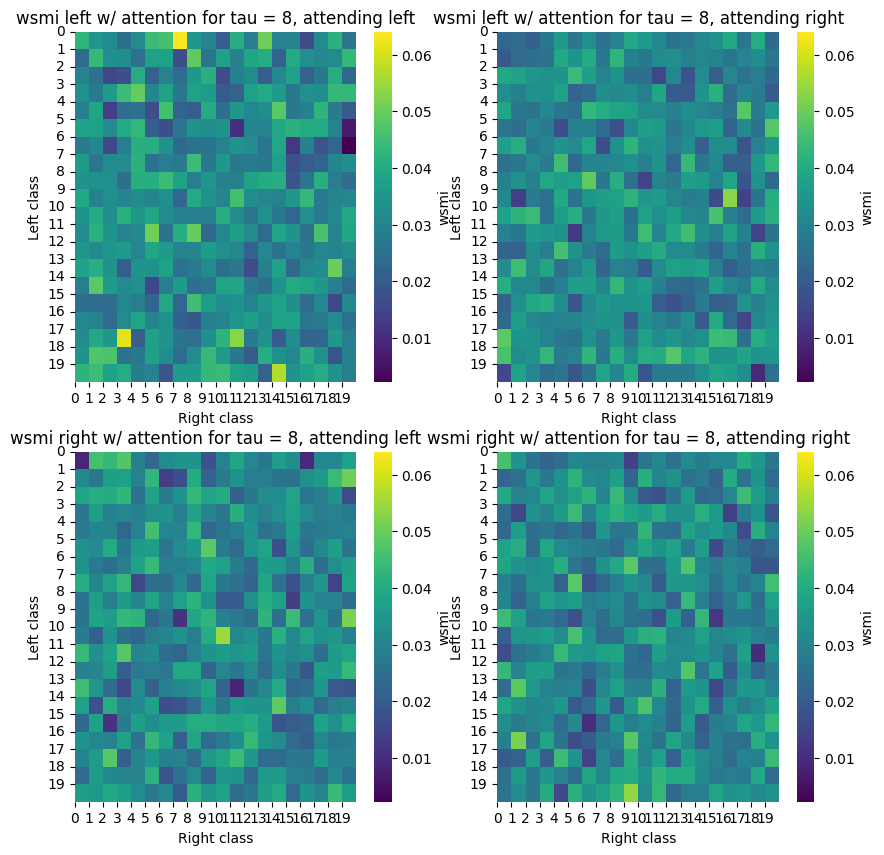

In [7]:
#--------plotting the results-------------
results_to_plot = {tau: copy.deepcopy(lr_split_structure) for tau in [8, 16, 32, 64]}

for tau, idx in zip([8, 16, 32, 64], range(4)):
    for cl in classes_left:
        for cr in classes_right:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                results_to_plot[tau][cl][cr][key] = wsmi_means[cl][cr][key][idx]

#==============================plotting================================
def calculate_vmin_vmax(results_to_plot, classes_left, classes_right):
    vmax = np.max([results_to_plot[cl][cr][key] 
                   for cl in classes_left for cr in classes_right for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']])
    vmin = np.min([results_to_plot[cl][cr][key] 
                   for cl in classes_left for cr in classes_right for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']])
    return vmin, vmax


vmin_64, vmax_64 = calculate_vmin_vmax(results_to_plot[64], classes_left, classes_right)
vmin_32, vmax_32 = calculate_vmin_vmax(results_to_plot[32], classes_left, classes_right)
vmin_16, vmax_16 = calculate_vmin_vmax(results_to_plot[16], classes_left, classes_right)
vmin_8, vmax_8 = calculate_vmin_vmax(results_to_plot[8], classes_left, classes_right)


def plot_4_hist(data, vmin, vmax, tau):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    sns.heatmap(np.array([[data[cl][cr]['left_attleft'] for cr in classes_right] for cl in classes_left]), ax=ax[0, 0], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'wsmi'}, vmin = vmin, vmax = vmax)
    ax[0,0].set_xticks(np.arange(0, 20))
    ax[0,0].set_yticks(np.arange(0, 20))
    ax[0,0].set_xticklabels(classes_right)
    ax[0,0].set_yticklabels(classes_left)
    ax[0,0].set_xlabel('Right class')
    ax[0,0].set_ylabel('Left class')
    ax[0,0].set_title(f'wsmi left w/ attention for tau = {tau}, attending left')

    sns.heatmap(np.array([[data[cl][cr]['right_attleft'] for cr in classes_right] for cl in classes_left]), ax=ax[1,0], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'wsmi'}, vmin = vmin, vmax = vmax)
    ax[1,0].set_xticks(np.arange(0, 20))
    ax[1,0].set_yticks(np.arange(0, 20))
    ax[1,0].set_xticklabels(classes_right)
    ax[1,0].set_yticklabels(classes_left)
    ax[1,0].set_xlabel('Right class')
    ax[1,0].set_ylabel('Left class')
    ax[1,0].set_title(f'wsmi right w/ attention for tau = {tau}, attending left')

    sns.heatmap(np.array([[data[cl][cr]['left_attright'] for cr in classes_right] for cl in classes_left]), ax=ax[0,1], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'wsmi'}, vmin = vmin, vmax = vmax)
    ax[0,1].set_xticks(np.arange(0, 20))
    ax[0,1].set_yticks(np.arange(0, 20))
    ax[0,1].set_xticklabels(classes_right)
    ax[0,1].set_yticklabels(classes_left)
    ax[0,1].set_xlabel('Right class')
    ax[0,1].set_ylabel('Left class')
    ax[0,1].set_title(f'wsmi left w/ attention for tau = {tau}, attending right')

    sns.heatmap(np.array([[data[cl][cr]['right_attright'] for cr in classes_right] for cl in classes_left]), ax=ax[1,1], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'wsmi'}, vmin = vmin, vmax = vmax)
    ax[1,1].set_xticks(np.arange(0, 20))
    ax[1,1].set_yticks(np.arange(0, 20))
    ax[1,1].set_xticklabels(classes_right)
    ax[1,1].set_yticklabels(classes_left)
    ax[1,1].set_xlabel('Right class')
    ax[1,1].set_ylabel('Left class')
    ax[1,1].set_title(f'wsmi right w/ attention for tau = {tau}, attending right')

    plt.show()

plot_4_hist(results_to_plot[64], vmin_64, vmax_64, 64)
plot_4_hist(results_to_plot[32], vmin_32, vmax_32, 32)
plot_4_hist(results_to_plot[16], vmin_16, vmax_16, 16)
plot_4_hist(results_to_plot[8], vmin_8, vmax_8, 8)

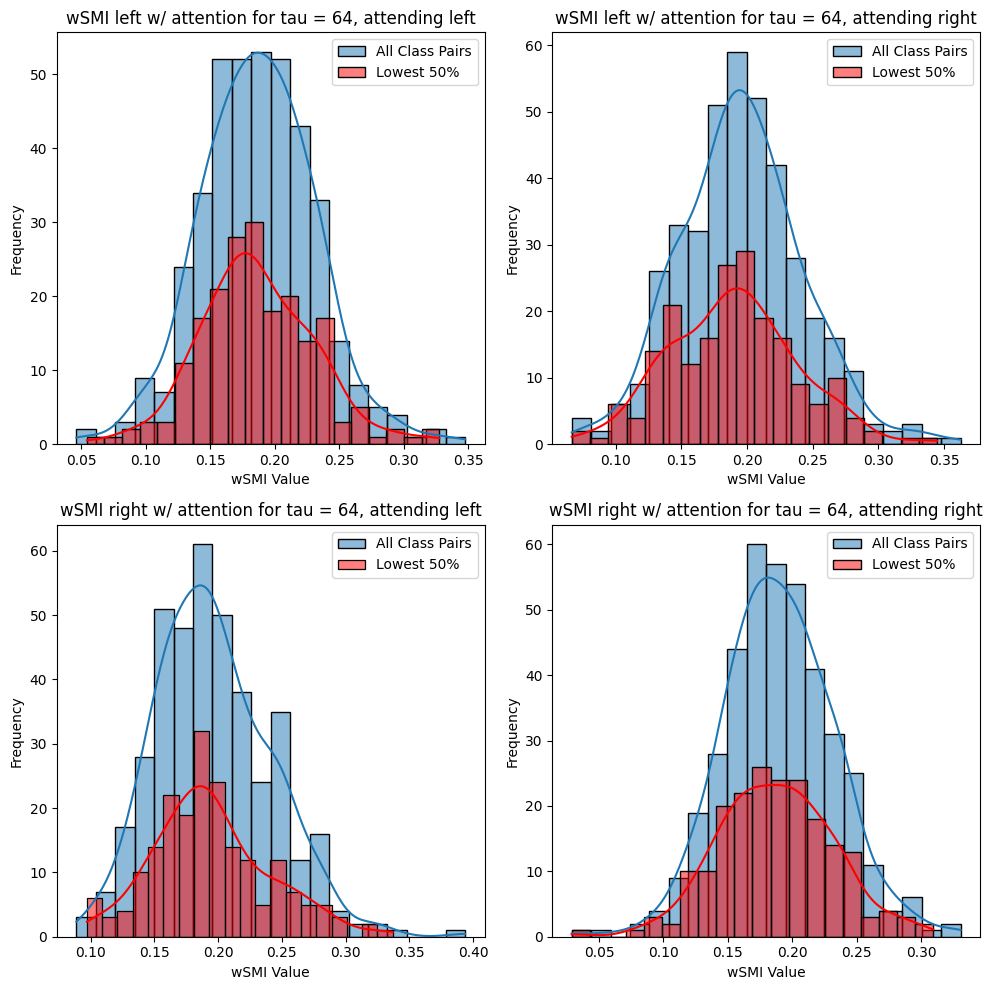

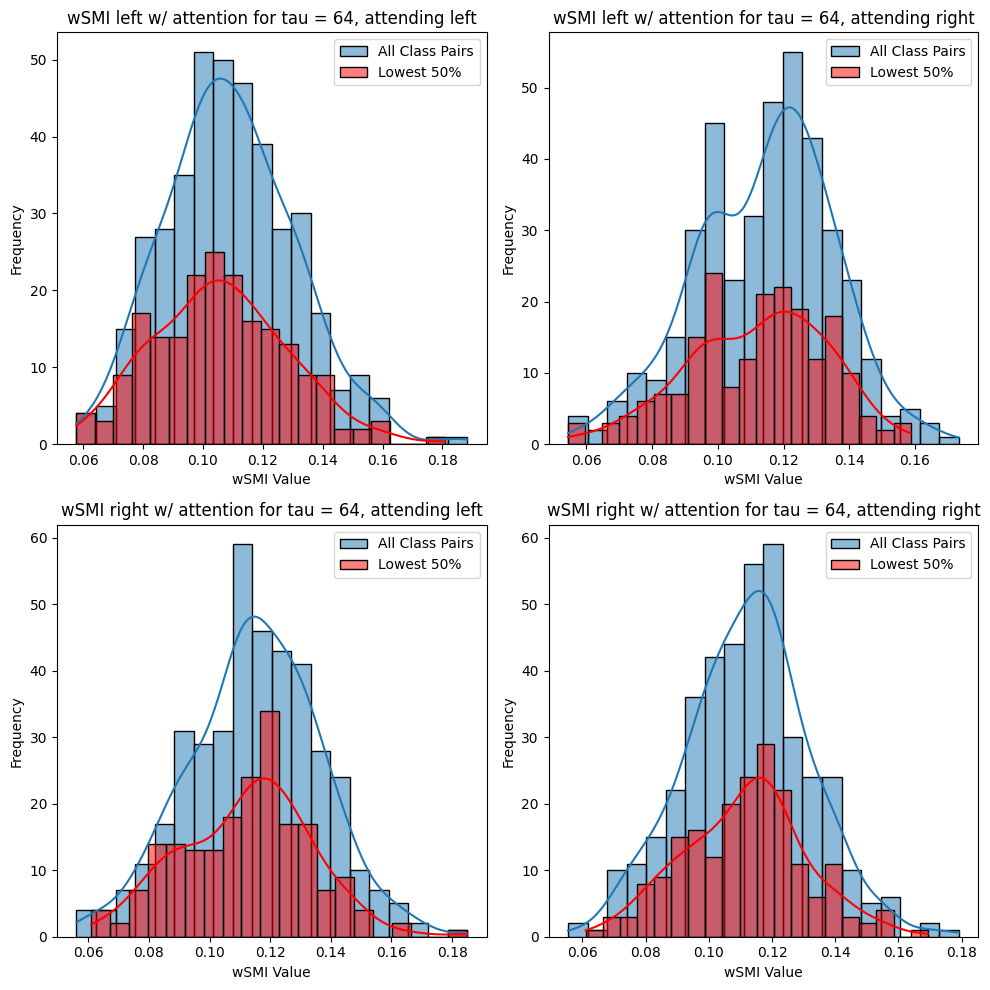

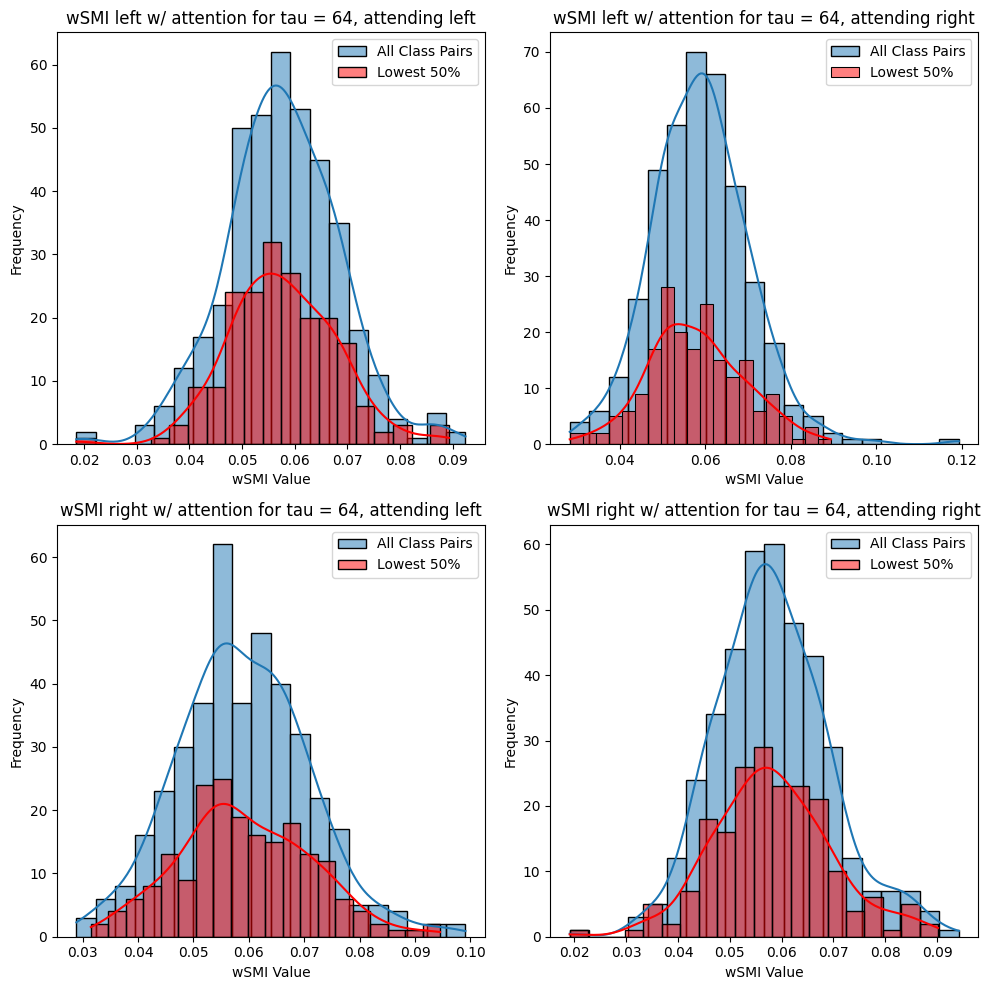

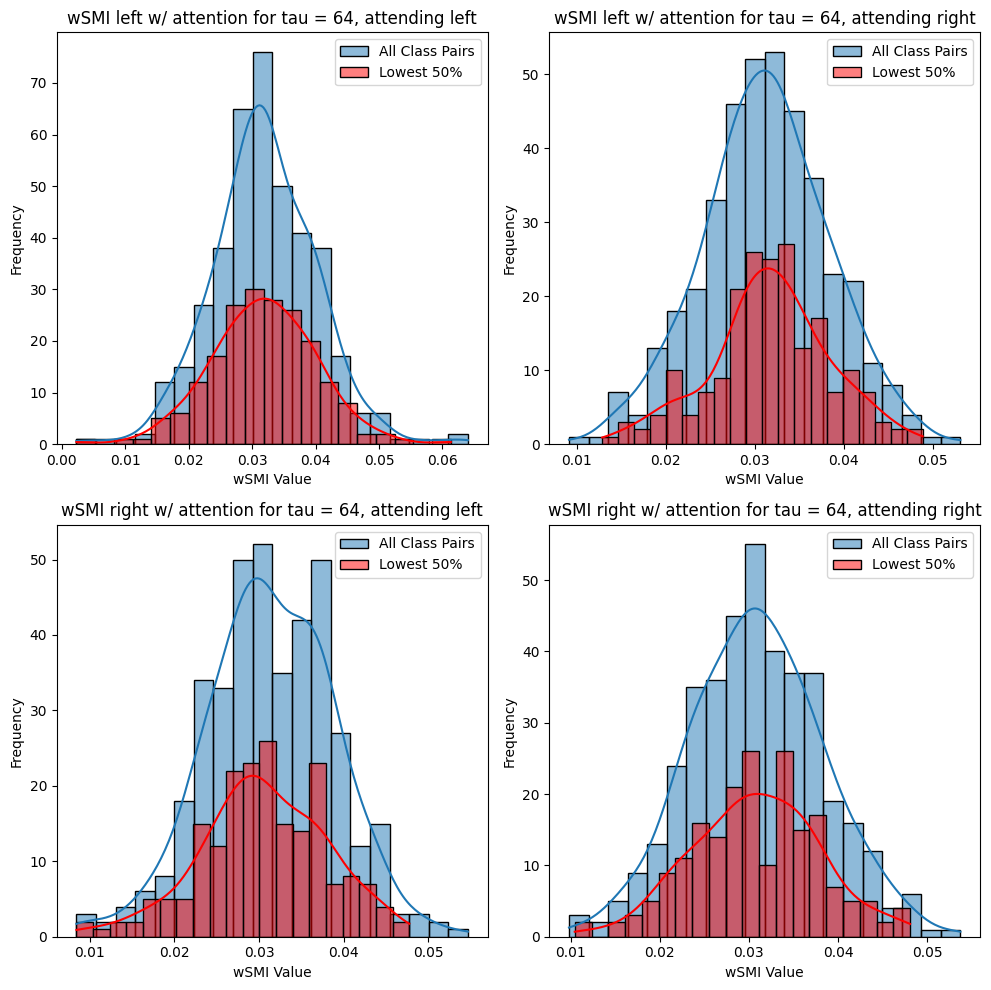

In [9]:
lowest_classes =  [(np.int64(12), np.int64(18)), (np.int64(18), np.int64(12)), (np.int64(7), np.int64(18)), (np.int64(14), np.int64(18)), (np.int64(18), np.int64(7)), (np.int64(12), np.int64(8)), (np.int64(8), np.int64(12)), (np.int64(7), np.int64(8)), (np.int64(8), np.int64(7)), (np.int64(18), np.int64(15)), (np.int64(16), np.int64(12)), (np.int64(18), np.int64(14)), (np.int64(6), np.int64(18)), (np.int64(15), np.int64(18)), (np.int64(8), np.int64(14)), (np.int64(11), np.int64(7)), (np.int64(17), np.int64(18)), (np.int64(7), np.int64(11)), (np.int64(16), np.int64(7)), (np.int64(3), np.int64(12)), (np.int64(11), np.int64(12)), (np.int64(18), np.int64(17)), (np.int64(18), np.int64(6)), (np.int64(12), np.int64(10)), (np.int64(12), np.int64(11)), (np.int64(0), np.int64(18)), (np.int64(18), np.int64(2)), (np.int64(7), np.int64(10)), (np.int64(7), np.int64(16)), (np.int64(2), np.int64(18)), (np.int64(18), np.int64(0)), (np.int64(12), np.int64(6)), (np.int64(7), np.int64(1)), (np.int64(6), np.int64(8)), (np.int64(12), np.int64(16)), (np.int64(12), np.int64(1)), (np.int64(7), np.int64(19)), (np.int64(17), np.int64(8)), (np.int64(10), np.int64(7)), (np.int64(18), np.int64(13)), (np.int64(6), np.int64(12)), (np.int64(12), np.int64(19)), (np.int64(19), np.int64(12)), (np.int64(12), np.int64(5)), (np.int64(9), np.int64(12)), (np.int64(4), np.int64(18)), (np.int64(10), np.int64(12)), (np.int64(18), np.int64(4)), (np.int64(6), np.int64(17)), (np.int64(8), np.int64(17)), (np.int64(16), np.int64(17)), (np.int64(16), np.int64(15)), (np.int64(8), np.int64(6)), (np.int64(7), np.int64(9)), (np.int64(7), np.int64(5)), (np.int64(17), np.int64(6)), (np.int64(17), np.int64(16)), (np.int64(11), np.int64(14)), (np.int64(18), np.int64(5)), (np.int64(7), np.int64(6)), (np.int64(6), np.int64(10)), (np.int64(13), np.int64(18)), (np.int64(14), np.int64(8)), (np.int64(18), np.int64(3)), (np.int64(8), np.int64(0)), (np.int64(6), np.int64(5)), (np.int64(1), np.int64(7)), (np.int64(15), np.int64(8)), (np.int64(16), np.int64(14)), (np.int64(0), np.int64(8)), (np.int64(8), np.int64(2)), (np.int64(1), np.int64(12)), (np.int64(12), np.int64(3)), (np.int64(16), np.int64(0)), (np.int64(19), np.int64(7)), (np.int64(19), np.int64(6)), (np.int64(5), np.int64(7)), (np.int64(3), np.int64(7)), (np.int64(19), np.int64(17)), (np.int64(9), np.int64(7)), (np.int64(12), np.int64(9)), (np.int64(6), np.int64(13)), (np.int64(12), np.int64(4)), (np.int64(7), np.int64(3)), (np.int64(6), np.int64(9)), (np.int64(9), np.int64(6)), (np.int64(13), np.int64(6)), (np.int64(15), np.int64(17)), (np.int64(10), np.int64(6)), (np.int64(8), np.int64(4)), (np.int64(11), np.int64(6)), (np.int64(6), np.int64(11)), (np.int64(6), np.int64(1)), (np.int64(5), np.int64(6)), (np.int64(1), np.int64(6)), (np.int64(14), np.int64(16)), (np.int64(15), np.int64(0)), (np.int64(6), np.int64(0)), (np.int64(17), np.int64(15)), (np.int64(5), np.int64(18)), (np.int64(6), np.int64(14)), (np.int64(4), np.int64(6)), (np.int64(14), np.int64(11)), (np.int64(13), np.int64(8)), (np.int64(7), np.int64(15)), (np.int64(14), np.int64(6)), (np.int64(10), np.int64(14)), (np.int64(7), np.int64(2)), (np.int64(14), np.int64(10)), (np.int64(13), np.int64(16)), (np.int64(1), np.int64(14)), (np.int64(17), np.int64(11)), (np.int64(17), np.int64(10)), (np.int64(3), np.int64(6)), (np.int64(8), np.int64(13)), (np.int64(11), np.int64(17)), (np.int64(0), np.int64(1)), (np.int64(6), np.int64(7)), (np.int64(18), np.int64(16)), (np.int64(11), np.int64(15)), (np.int64(2), np.int64(6)), (np.int64(3), np.int64(18)), (np.int64(6), np.int64(15)), (np.int64(4), np.int64(12)), (np.int64(11), np.int64(0)), (np.int64(0), np.int64(6)), (np.int64(6), np.int64(4)), (np.int64(6), np.int64(19)), (np.int64(4), np.int64(8)), (np.int64(0), np.int64(3)), (np.int64(15), np.int64(12)), (np.int64(0), np.int64(16)), (np.int64(6), np.int64(3)), (np.int64(1), np.int64(15)), (np.int64(3), np.int64(2)), (np.int64(16), np.int64(3)), (np.int64(16), np.int64(4)), (np.int64(17), np.int64(2)), (np.int64(0), np.int64(11)), (np.int64(5), np.int64(12)), (np.int64(15), np.int64(6)), (np.int64(5), np.int64(17)), (np.int64(13), np.int64(15)), (np.int64(11), np.int64(4)), (np.int64(4), np.int64(10)), (np.int64(12), np.int64(2)), (np.int64(15), np.int64(7)), (np.int64(8), np.int64(5)), (np.int64(2), np.int64(8)), (np.int64(15), np.int64(5)), (np.int64(5), np.int64(14)), (np.int64(15), np.int64(9)), (np.int64(2), np.int64(16)), (np.int64(15), np.int64(13)), (np.int64(4), np.int64(15)), (np.int64(17), np.int64(19)), (np.int64(15), np.int64(1)), (np.int64(15), np.int64(16)), (np.int64(14), np.int64(1)), (np.int64(9), np.int64(15)), (np.int64(16), np.int64(18)), (np.int64(12), np.int64(15)), (np.int64(14), np.int64(5)), (np.int64(14), np.int64(19)), (np.int64(11), np.int64(5)), (np.int64(13), np.int64(12)), (np.int64(14), np.int64(9)), (np.int64(7), np.int64(4)), (np.int64(16), np.int64(2)), (np.int64(4), np.int64(16)), (np.int64(17), np.int64(3)), (np.int64(15), np.int64(11)), (np.int64(2), np.int64(17)), (np.int64(3), np.int64(17)), (np.int64(16), np.int64(13)), (np.int64(0), np.int64(19)), (np.int64(0), np.int64(10)), (np.int64(14), np.int64(4)), (np.int64(16), np.int64(6)), (np.int64(3), np.int64(15)), (np.int64(5), np.int64(11)), (np.int64(13), np.int64(11)), (np.int64(5), np.int64(10)), (np.int64(6), np.int64(16)), (np.int64(9), np.int64(4)), (np.int64(4), np.int64(14)), (np.int64(4), np.int64(3)), (np.int64(17), np.int64(5)), (np.int64(15), np.int64(3)), (np.int64(6), np.int64(6)), (np.int64(14), np.int64(2)), (np.int64(10), np.int64(17)), (np.int64(8), np.int64(15)), (np.int64(14), np.int64(3)), (np.int64(14), np.int64(0)), (np.int64(14), np.int64(7)), (np.int64(7), np.int64(17)), (np.int64(19), np.int64(0)), (np.int64(3), np.int64(14)), (np.int64(3), np.int64(3))]
results_to_plot_low = {tau: copy.deepcopy(lr_split_structure) for tau in [8, 16, 32, 64]}

for tau, idx in zip([8, 16, 32, 64], range(4)):
    for cl in classes_left:
        for cr in classes_right:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                results_to_plot[tau][cl][cr][key] = wsmi_means[cl][cr][key][idx]


for tau, idx in zip([8, 16, 32, 64], range(4)):
    for cl in classes_left:
        for cr in classes_right:
            if (cl, cr) in lowest_classes:
                for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                    results_to_plot_low[tau][cl][cr][key] = wsmi_means[cl][cr][key][idx]
            else:
                for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                    results_to_plot_low[tau][cl][cr][key] = -1



def hist_low_plot(data, data_low, tau):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    # Flatten the extracted wSMI values into 1D lists before plotting
    hist_values_all = [data[tau][cl][cr]['left_attleft']
                        for cl in classes_left for cr in classes_right]
    hist_values_low = [data_low[tau][cl][cr]['left_attleft']
                        for cl in classes_left for cr in classes_right if data_low[tau][cl][cr]['left_attleft'] != -1]

    sns.histplot(hist_values_all, ax=ax[0, 0], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(hist_values_low, ax=ax[0, 0], bins=20, kde=True, label="Lowest 50%", color='red', alpha=0.5)
    ax[0,0].set_title('wSMI left w/ attention for tau = 64, attending left')
    ax[0,0].set_xlabel('wSMI Value')
    ax[0,0].set_ylabel('Frequency')
    ax[0,0].legend()

    # Repeat for the other plots
    hist_values_all = [data[tau][cl][cr]['right_attleft']
                        for cl in classes_left for cr in classes_right]
    hist_values_low = [data_low[tau][cl][cr]['right_attleft']
                        for cl in classes_left for cr in classes_right if data_low[tau][cl][cr]['right_attleft'] != -1]

    sns.histplot(hist_values_all, ax=ax[1, 0], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(hist_values_low, ax=ax[1, 0], bins=20, kde=True, label="Lowest 50%", color='red', alpha=0.5)
    ax[1,0].set_title('wSMI right w/ attention for tau = 64, attending left')
    ax[1,0].set_xlabel('wSMI Value')
    ax[1,0].set_ylabel('Frequency')
    ax[1,0].legend()

    hist_values_all = [data[tau][cl][cr]['left_attright']
                        for cl in classes_left for cr in classes_right]
    hist_values_low = [data_low[tau][cl][cr]['left_attright']
                        for cl in classes_left for cr in classes_right if data_low[tau][cl][cr]['left_attright'] != -1]

    sns.histplot(hist_values_all, ax=ax[0, 1], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(hist_values_low, ax=ax[0, 1], bins=20, kde=True, label="Lowest 50%", color='red', alpha=0.5)
    ax[0,1].set_title('wSMI left w/ attention for tau = 64, attending right')
    ax[0,1].set_xlabel('wSMI Value')
    ax[0,1].set_ylabel('Frequency')
    ax[0,1].legend()

    hist_values_all = [data[tau][cl][cr]['right_attright']
                        for cl in classes_left for cr in classes_right]
    hist_values_low = [data_low[tau][cl][cr]['right_attright']
                        for cl in classes_left for cr in classes_right if data_low[tau][cl][cr]['right_attright'] != -1]

    sns.histplot(hist_values_all, ax=ax[1, 1], bins=20, kde=True, label="All Class Pairs")
    sns.histplot(hist_values_low, ax=ax[1, 1], bins=20, kde=True, label="Lowest 50%", color='red', alpha=0.5)
    ax[1,1].set_title('wSMI right w/ attention for tau = 64, attending right')
    ax[1,1].set_xlabel('wSMI Value')
    ax[1,1].set_ylabel('Frequency')
    ax[1,1].legend()

    plt.tight_layout()
    plt.show()

hist_low_plot(results_to_plot, results_to_plot_low, 64)
hist_low_plot(results_to_plot, results_to_plot_low, 32)
hist_low_plot(results_to_plot, results_to_plot_low, 16)
hist_low_plot(results_to_plot, results_to_plot_low, 8)